In [1]:
import sys
import lib.dragon
sys.modules['dragon'] = sys.modules['lib.dragon']

In [2]:
import os
import sys
import importlib
import graphviz
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import openml

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from dragon.search_space.bricks_variables import mlp_var, identity_var, operations_var, mlp_const_var, dag_var, node_var, activation_var
from dragon.search_space.base_variables import CatVar, Constant, DynamicBlock, IntVar, FloatVar, ArrayVar, Variable
from dragon.search_space.dag_encoding import AdjMatrix, Node
from dragon.search_space.dag_variables import NodeVariable, HpVar
from dragon.search_operators.base_neighborhoods import ArrayInterval, DynamicBlockInterval, CatInterval, ConstantInterval
from dragon.search_operators.dag_neighborhoods import CatHpInterval, NodeInterval
from dragon.utils.plot_functions import draw_cell, load_archi, str_operations

In [3]:
class MetaArchi(nn.Module):
    def __init__(self, args, input_shape):
        super().__init__()
        # Number of features, here equals to 16
        self.input_shape = input_shape

        # We create the DAG using the WeightsAdjCell module
        assert isinstance(args['Dag'], AdjMatrix), f"The 'Dag' argument should be an 'AdjMatrix'. Got {type(args['Dag'])} instead."
        self.dag = args['Dag']
        print(f"DAG: {self.dag}")
        self.dag.set(input_shape)


    def forward(self, X):
        return self.dag(X)
    def set_prediction_to_save(self, name, df):
        if hasattr(self, "prediction"):
            self.prediction[name] = df
        else:
            self.prediction = {name: df}
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        full_path = os.path.join(path, "best_model.pth")
        torch.save(self.state_dict(), full_path)
        if hasattr(self, "prediction"):
            for k in self.prediction.keys():
                self.prediction[k].to_csv(os.path.join(path, f"best_model_{k}_outputs.csv"))

In [4]:
df = pd.read_csv(f"/home/echikhao/Bureau/DRAGON-SR/data/6000_points.csv")
if 'system:index' in df.columns:
    df.drop('system:index', axis=1, inplace=True)
    
if '.geo' in df.columns:
    df.drop('.geo', axis=1, inplace=True)
df['NDVI'] = (df['B8']-df['B4'])/(df['B8']+df['B4'])
df.to_csv('/home/echikhao/Bureau/DRAGON-SR/data/ndvi.csv')

In [5]:
df.head()

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,QA60,date,lat,lon,NDVI
0,1380,3202,2266,1245,1101,1240,1413,1716,1944,1959,2250,0,2023-03-23,37.335014,-95.326731,0.224758
1,1317,49,42,889,503,288,247,208,190,141,146,0,2023-06-04,-21.011541,-124.765524,-0.342657
2,1162,2031,1475,951,850,968,1036,1136,1265,1185,1298,0,2023-01-26,11.062935,-11.792313,0.100790
3,1286,1291,444,980,823,532,832,1995,2736,2485,3134,0,2023-10-24,-1.910390,114.546423,0.647332
4,1381,2050,1363,1126,1016,975,1155,1617,1845,1806,2015,0,2023-04-13,27.868199,120.743335,0.298813


In [6]:
X = df[['B8', 'B4']]
z = pd.DataFrame(df['NDVI'])

In [277]:
X = pd.DataFrame({
    "x": np.random.normal(0, 1, 1000),
    "y": np.random.normal(0, 1, 1000)
})

z = pd.DataFrame({
    "z": (X["x"] - X["y"]) / (X["x"] + X["y"] + 1e-10)
})

In [241]:
X = pd.DataFrame({
    "x": np.random.normal(0, 1, 10000),
    "y": np.random.normal(0, 1, 10000)
})

# Garder seulement les lignes où -1 <= x <= 1 et -1 <= y <= 1
mask = (X["x"] >= 0) & (X["x"] <= 1) & (X["y"] >= 0) & (X["y"] <= 1)
X = X[mask].reset_index(drop=True)

z = pd.DataFrame({
    "z": (X["x"] - X["y"]) / (X["x"] + X["y"] + 1e-10)
})

In [278]:
X.head()

,x,y
0,0.017823,0.159227
1,0.391984,-2.308211
2,1.733828,-1.835075
3,-0.735176,0.392916
4,-0.931916,0.639554


In [279]:
z.head()

,z
0,-0.798664
1,-1.409121
2,-35.249291
3,3.296006
4,5.375075


In [280]:
z.count

<bound method DataFrame.count of              z
0    -0.798664
1    -1.409121
2   -35.249291
3     3.296006
4     5.375075
..         ...
995   0.055852
996   0.650509
997   0.313961
998   1.558749
999   0.691580

[1000 rows x 1 columns]>

In [281]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_set = RegressionDataset(X, z)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [282]:
class SumFeatures(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape

    def forward(self, X):
        # X: (batch, features)
        return X.sum(dim=-1, keepdim=True)

    def modify_operation(self, input_shape):
        self.input_shape = input_shape

    def __repr__(self):
        return "SumFeatures()"


In [283]:
class Inverse(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape

    def forward(self, X):
        return 1 / (X + 1e-8)

    def modify_operation(self, input_shape):
        self.input_shape = input_shape

    def __repr__(self):
        return "Inverse()"


In [284]:
class Negate(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape

    def forward(self, X):
        return -X

    def modify_operation(self, input_shape):
        self.input_shape = input_shape

    def __repr__(self):
        return "Negate()"


In [285]:
class SelectFeatures(nn.Module):
    def __init__(self, input_shape, feature_indices=None):
        super().__init__()
        self.input_shape = input_shape
        self.feature_indices = feature_indices

    def forward(self, X, h=None):
        if self.feature_indices is None:
            return X

        n_features = X.shape[-1]
        idx = torch.as_tensor(self.feature_indices, device=X.device)

        if idx.max() >= n_features:
            raise ValueError(
                f"SelectFeatures: index {idx.max().item()} "
                f"out of bounds for input with {n_features} features"
            )

        return X[..., idx]


    def modify_operation(self, input_shape):
        self.input_shape = input_shape

    def __repr__(self):
        return f"SelectFeatures(feature_indices={self.feature_indices})"


In [286]:
from dragon.search_operators.dag_neighborhoods import HpInterval
from dragon.search_space.bricks_variables import (
    identity_var,
    operations_var,
    dag_var,
    node_var
)
from dragon.search_space.bricks.basics import Identity

unary_var = HpVar(
    "UnaryOp",
    CatVar(
        "UnaryOpType",
        features=[Identity, Inverse, Negate],
        neighbor=CatInterval()
    ),
    hyperparameters={},
    neighbor=HpInterval()
)
select_features_var = HpVar(
    "SelectFeatures",
    Constant("SelectFeaturesOp", SelectFeatures, neighbor=ConstantInterval()),
    hyperparameters={
        "feature_indices": CatVar(
            "feature_indices",
            features=[[0], [1]],
            neighbor=CatInterval()
        )
    },
    neighbor=HpInterval()
)

sum_var = HpVar(
    "Sum",
    Constant("SumOp", SumFeatures, neighbor=ConstantInterval()),
    hyperparameters={},
    neighbor=HpInterval()
)


candidate_operations = operations_var(
    "CandidateOperations",
    size=10,
    candidates=[
        select_features_var,
        identity_var("Identity"),
        unary_var,
        sum_var
    ],
    combiner_features = ['add', 'mul'], # 'sub', 'divide'
    activations=[Constant(
        "id",
        value=nn.Identity(),
        neighbor=ConstantInterval()
    )]
)


dag = dag_var("Dag", candidate_operations, complexity=4)
print("Example DAG:", dag.random())


Example DAG: NODES: [
(combiner) add -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) mul -- (name) <class '__main__.SumFeatures'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) mul -- (name) <class '__main__.SumFeatures'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) add -- (name) <class '__main__.SelectFeatures'> -- (hp) {'feature_indices': [0]} -- (activation) Identity() -- , 
(combiner) add -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- ] | MATRIX:[[0, 1, 0, 1, 1], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]


In [287]:
from dragon.search_space.base_variables import ArrayVar
from dragon.search_operators.base_neighborhoods import ArrayInterval

search_space = ArrayVar(dag, label="Search Space", neighbor=ArrayInterval())

# Loss

In [288]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()

def loss_function(args, idx, *kwargs):
    labels = [e.label for e in search_space]
    args = dict(zip(labels, args))

    model = MetaArchi(args, input_shape=(2,)).to(device)
    model.eval()

    all_pred = []
    all_true = []

    with torch.no_grad():
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            all_pred.append(pred.detach().cpu())
            all_true.append(yb.detach().cpu())

    pred_all = torch.cat(all_pred).squeeze()
    true_all = torch.cat(all_true).squeeze()

    mse = loss_fn(pred_all, true_all)
    
  
    
    loss = mse.item()
    
    print(f"Idx = {idx}, MSE = {mse.item():.6f} ")

    df = pd.DataFrame({
        "pred": pred_all.numpy(),
        "true": true_all.numpy()
    })
    model.set_prediction_to_save("test", df)

    return loss, model

In [289]:
loss, model = loss_function(minimal_graph, idx="test")
print("Initial MSE:", loss)


DAG: NODES: [
(combiner) mul -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) add -- (name) <class '__main__.SelectFeatures'> -- (hp) {'feature_indices': [0]} -- (activation) Identity() -- , 
(combiner) add -- (name) <class '__main__.SelectFeatures'> -- (hp) {'feature_indices': [1]} -- (activation) Identity() -- , 
(combiner) sub -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) add -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) divide -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- ] | MATRIX:[[0, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0]]
Idx = test, MSE = 0.000000 
Initial MSE: 6.693980036942548e-09


# Config 1

In [290]:
from dragon.search_space.bricks.basics import Identity


m_dag = [Node(combiner='add', operation=Identity, hp = {}, activation=nn.Identity()), 
         Node(combiner='concat', operation=SumFeatures, hp = {}, activation=nn.Identity()), 
         Node(combiner='mul', operation=Negate, hp={}, activation=nn.Identity()), 
         Node(combiner='concat', operation=SelectFeatures, hp={'feature_indices': [0]}, activation=nn.Identity()), 
         Node(combiner='concat', operation=SelectFeatures, hp={'feature_indices': [1]}, activation=nn.Identity()), 
         Node(combiner='add', operation=Inverse, hp={}, activation=nn.Identity()), 
         Node(combiner='mul', operation=Identity, hp={}, activation=nn.Identity()),
         Node(combiner='add', operation=Inverse, hp={}, activation=nn.Identity())]
n_dag = np.array([[0, 1, 1, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1],
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  ])

minimal_graph = [AdjMatrix(matrix=n_dag, operations=m_dag)]

# Config 2

In [291]:
from dragon.search_space.bricks.basics import Identity

m_dag = [
    Node(combiner='mul', operation=Identity, 
         hp={}, activation=nn.Identity()),

    Node(combiner='add', operation=SelectFeatures, 
         hp={'feature_indices': [0]}, activation=nn.Identity()),
    
    Node(combiner='add', operation=SelectFeatures, 
         hp={'feature_indices': [1]}, activation=nn.Identity()),
    
    Node(combiner='sub', operation=Identity, 
         hp={}, activation=nn.Identity()),
    
    Node(combiner='add', operation=Identity, 
         hp={}, activation=nn.Identity()),
    
    Node(combiner='divide', operation=Identity, 
         hp={}, activation=nn.Identity()),
]



n_dag = np.array([
    [0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0],
])

minimal_graph = [AdjMatrix(matrix=n_dag, operations=m_dag)]

In [292]:
from dragon.search_algorithm.mutant_ucb import Mutant_UCB

search_algorithm = Mutant_UCB(
    search_space,
    save_dir="save/NDVI",
    T= 1000,
    N=1,
    K=500,
    E=1000,
    # decreasing_E = True,
    evaluation=loss_function,
    nb_mutations = 2
    # models=[minimal_graph],
    # verbose= True
)

search_algorithm.run()

# pop_path: save_dir
# clean_all=False

2026-02-03 10:42:23,575 | WARNING | Install mpi4py if you want to use the distributed version.
2026-02-03 10:42:23,575 | INFO | save/NDVI already exists. Deleting it.
2026-02-03 10:42:23,742 | INFO | The whole population has been created (size = 500), 500 have been randomy initialized.
DAG: NODES: [
(combiner) add -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) add -- (name) <class '__main__.SumFeatures'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) add -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) add -- (name) <class '__main__.Inverse'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) add -- (name) <class '__main__.SelectFeatures'> -- (hp) {'feature_indices': [1]} -- (activation) Identity() -- ] | MATRIX:[[0, 1, 0, 0, 1], [0, 0, 1, 1, 0], [0, 0, 0, 1, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]
Idx = 0, MSE = 597.638306 
2026-02-03 10

Model giving a score of  82.89 %:


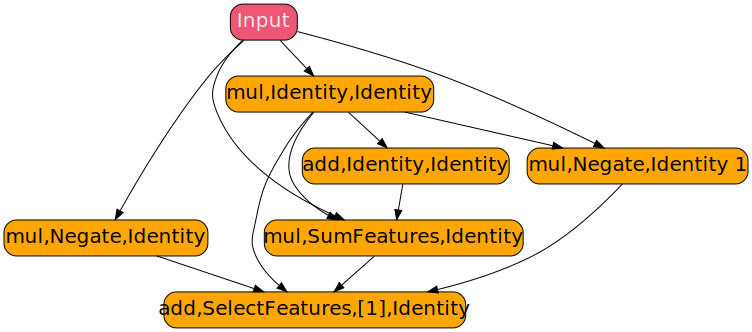

In [271]:
import graphviz
from dragon.utils.plot_functions import draw_cell, load_archi, str_operations

def draw_graph(n_dag, m_dag, output_file, best_model, act="Identity()", name="Input"):
    G = graphviz.Digraph(
        output_file,
        format='pdf',
        node_attr={
            'nodesep': '0.02',
            'shape': 'box',
            'rankstep': '0.02',
            'fontsize': '20',
            "fontname": "sans-serif"
        }
    )

    # Draw the DAG cells
    G, g_nodes = draw_cell(G, n_dag, m_dag, "#ffa600", [], name_input=name, color_input="#ef5675")

    return G

# Load the best model
best_model = load_archi("save/NDVI/best_model/x.pkl")
labels = [e.label for e in search_space]
best_model = dict(zip(labels, best_model))
m_dag = best_model['Dag'].matrix
n_dag = str_operations(best_model["Dag"].operations)

# Draw the graph
graph = draw_graph(n_dag, m_dag, "save/_mutant/best_archi", best_model)
print(f'Model giving a score of ', np.round((1-search_algorithm.min_loss)*100, 2), '%:')
graph


In [272]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import sys
from io import StringIO

def plot_loss_landscape_filtered(best_config_array, search_space, loss_fn, 
                                  target_loss=0.09, tolerance=0.01, max_samples=50):
    """
    Sample neighbors and keep only those with loss close to target_loss.
    Also extracts and displays the formula for each valid architecture.
    """
    target_min = 0
    target_max = target_loss + tolerance
    
    print(f"Sampling neighbors with loss in range [{target_min:.4f}, {target_max:.4f}]...")
    print(f"(trying up to {max_samples} neighbors)")
    
    valid_losses = []
    valid_configs = []  # Store configs for formula extraction
    total_tried = 0
    total_errors = 0
    
    # Suppress verbose output
    old_stdout = sys.stdout
    sys.stdout = StringIO()
    
    try:
        # Evaluate best config first
        print("Evaluating best config...", file=sys.stderr)
        try:
            loss_best, _ = loss_fn(best_config_array, idx="landscape_best")
            if target_min <= loss_best <= target_max:
                valid_losses.append(("Best", loss_best))
                valid_configs.append(best_config_array)
                print(f"✓ Best config: loss={loss_best:.6f}", file=sys.stderr)
            else:
                print(f"✗ Best config: loss={loss_best:.6f} (out of range)", file=sys.stderr)
        except Exception as e:
            print(f"✗ Best config failed: {type(e).__name__}", file=sys.stderr)
        
        # Sample neighbors until we find enough or hit max_samples
        i = 0
        while i < max_samples and len(valid_losses) < 15:
            print(f"Sampling neighbor {i+1} (valid: {len(valid_losses)-1 if valid_losses else 0})...", file=sys.stderr)
            
            try:
                neighbor = search_space.neighbor(deepcopy(best_config_array))
                total_tried += 1
                
                try:
                    loss_neighbor, _ = loss_fn(neighbor, idx=f"neighbor_{i}")
                    
                    # Check if in target range
                    if target_min <= loss_neighbor <= target_max:
                        valid_losses.append((f"N{i+1}", loss_neighbor))
                        valid_configs.append(neighbor)
                        print(f"✓ Neighbor {i+1}: loss={loss_neighbor:.6f}", file=sys.stderr)
                    else:
                        print(f"✗ Neighbor {i+1}: loss={loss_neighbor:.6f} (out of range)", file=sys.stderr)
                except (ValueError, RuntimeError, TypeError) as e:
                    total_errors += 1
                    print(f"✗ Neighbor {i+1} evaluation failed: {type(e).__name__}", file=sys.stderr)
                    
            except Exception as e:
                total_errors += 1
                print(f"✗ Neighbor {i+1} generation failed: {type(e).__name__}", file=sys.stderr)
            
            i += 1
    
    finally:
        sys.stdout = old_stdout
    
    if len(valid_losses) < 1:
        print(f"⚠ No architectures found in range [{target_min:.4f}, {target_max:.4f}]")
        print(f"  Tried: {total_tried}, Errors: {total_errors}")
        return
    
    # Extract labels and values
    labels = [item[0] for item in valid_losses]
    values = [item[1] for item in valid_losses]
    
    # Plot
    plt.figure(figsize=(14, 6))
    colors = ['darkred' if 'Best' in label else 'steelblue' for label in labels]
    bars = plt.bar(range(len(labels)), values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add target line
    plt.axhline(y=target_loss, color='green', linestyle='--', linewidth=2, label=f'Target loss ({target_loss:.4f})')
    plt.axhline(y=target_min, color='green', linestyle=':', linewidth=1, alpha=0.5)
    plt.axhline(y=target_max, color='green', linestyle=':', linewidth=1, alpha=0.5)
    
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=10)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title(f'Filtered Architectures: Loss ≈ {target_loss} (±{tolerance})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    # Extract and display formulas for each valid architecture
    print(f"\n{'='*70}")
    print(f"EXTRACTED FORMULAS FOR VALID ARCHITECTURES")
    print(f"{'='*70}\n")
    
    for label, loss, config in zip(labels, values, valid_configs):
        print(f"{label} (Loss: {loss:.6f})")
        print("-" * 70)
        
        try:
            # Convert array to dict format
            config_labels = [e.label for e in search_space]
            config_dict = dict(zip(config_labels, config))
            
            # Extract formula
            formula = graph_to_formula(config_dict['Dag'].matrix, X, config_dict['Dag'].operations)
            print(f"Formula: {formula}")
            
        except Exception as e:
            print(f"⚠ Could not extract formula: {type(e).__name__}: {str(e)[:100]}")
        
        print()
    
    # Print stats
    print(f"{'='*70}")
    print(f"✓ Found {len(valid_losses)} valid architectures out of {total_tried} sampled")
    print(f"  Generation errors: {total_errors}")
    print(f"  Mean loss: {np.mean(values):.6f}")
    print(f"  Std loss: {np.std(values):.6f}")

# Load best model as array
best_model_array = load_archi("save/NDVI/best_model/x.pkl")

# Plot filtered landscape (keeps only architectures with loss ≈ 0.09)
plot_loss_landscape_filtered(best_model_array, search_space, loss_function, 
                             target_loss=0.13, tolerance=0.01, max_samples=50)


Sampling neighbors with loss in range [0.0000, 0.1400]...
(trying up to 50 neighbors)


Evaluating best config...
✗ Best config: loss=0.171119 (out of range)
Sampling neighbor 1 (valid: 0)...
✗ Neighbor 1 evaluation failed: RuntimeError
Sampling neighbor 2 (valid: 0)...
✗ Neighbor 2: loss=287.540497 (out of range)
Sampling neighbor 3 (valid: 0)...
✗ Neighbor 3: loss=0.227807 (out of range)
Sampling neighbor 4 (valid: 0)...
✗ Neighbor 4 evaluation failed: RuntimeError
Sampling neighbor 5 (valid: 0)...
✗ Neighbor 5: loss=383141.468750 (out of range)
Sampling neighbor 6 (valid: 0)...
✗ Neighbor 6 evaluation failed: RuntimeError
Sampling neighbor 7 (valid: 0)...
✗ Neighbor 7 evaluation failed: RuntimeError
Sampling neighbor 8 (valid: 0)...
✗ Neighbor 8: loss=1.000047 (out of range)
Sampling neighbor 9 (valid: 0)...
✗ Neighbor 9: loss=61418279796736.000000 (out of range)
Sampling neighbor 10 (valid: 0)...
✗ Neighbor 10: loss=2.906317 (out of range)
Sampling neighbor 11 (valid: 0)...
✗ Neighbor 11: loss=0.699406 (out of range)
Sampling neighbor 12 (valid: 0)...
✗ Neighbor 12: l

⚠ No architectures found in range [0.0000, 0.1400]
  Tried: 50, Errors: 12


✗ Neighbor 37: loss=3.779618 (out of range)
Sampling neighbor 38 (valid: 0)...
✗ Neighbor 38 evaluation failed: RuntimeError
Sampling neighbor 39 (valid: 0)...
✗ Neighbor 39: loss=8.164025 (out of range)
Sampling neighbor 40 (valid: 0)...
✗ Neighbor 40 evaluation failed: RuntimeError
Sampling neighbor 41 (valid: 0)...
✗ Neighbor 41: loss=0.749077 (out of range)
Sampling neighbor 42 (valid: 0)...
✗ Neighbor 42: loss=0.665701 (out of range)
Sampling neighbor 43 (valid: 0)...
✗ Neighbor 43 evaluation failed: RuntimeError
Sampling neighbor 44 (valid: 0)...
✗ Neighbor 44: loss=92641546993664.000000 (out of range)
Sampling neighbor 45 (valid: 0)...
✗ Neighbor 45 evaluation failed: RuntimeError
Sampling neighbor 46 (valid: 0)...
✗ Neighbor 46: loss=1.088807 (out of range)
Sampling neighbor 47 (valid: 0)...
✗ Neighbor 47: loss=4.675517 (out of range)
Sampling neighbor 48 (valid: 0)...
✗ Neighbor 48: loss=16.175707 (out of range)
Sampling neighbor 49 (valid: 0)...
✗ Neighbor 49: loss=1.109033 (

In [273]:
def op_tensors(input, combiner):
    if combiner == "add":
        op = '+'
    if combiner == "mul":
        op = '*'
    if combiner == "sub":
        op = '-'
    if combiner == "divide":
        op = '/'
    
    n = max(len(l) for l in input)
    for l in input:
        if len(l) < n:
            l += ['0'] * (n - len(l))
            l.reverse()
    result = []
    for l in input:
        for j in range(len(l)):
            if len(result) < j + 1:
                result.append(l[j])
            else:
                result[j] = f"({result[j]}) {op} ({l[j]})"
    return result

In [274]:
from sympy import simplify

def graph_to_formula(adj_matrix, X, nodes):
    n = adj_matrix.shape[0]

    # Input node
    shape = X.shape[-1]
    input = ["x" + str(i) for i in range(shape)]

    out_dict = {}
    out_dict[0] = input

    for i in range(1, n):
        parents = [j for j in range(n) if adj_matrix[j, i] == 1]
        input = [out_dict[j] for j in parents]


        #Combiners
        combiner = nodes[i].combiner
        operation = nodes[i].operation

        out = op_tensors(input, combiner)                        
                        
        #Operations

        if isinstance(operation, SelectFeatures) or operation.__class__.__name__ == 'SelectFeatures':

            feature_indices = nodes[i].hp.get('feature_indices', None)
            out = [out[i] for i in feature_indices] if feature_indices is not None else out

        if isinstance(operation, SumFeatures) or operation.__class__.__name__ == 'SumFeatures':
            # Sum symbolic expressions by joining with +
            summed_expr = ' + '.join(f'({o})' for o in out)
            out = [summed_expr]
        
        if isinstance(operation, Inverse) or operation.__class__.__name__ == 'Inverse':
            out = ['1/(' + o + ')' for o in out]
        
        if isinstance(operation, Negate) or operation.__class__.__name__ == 'Negate':
            out = ['-(' + o + ')' for o in out]

        out_dict[i] = out


    
    expr = out_dict[n - 1][0]
    simplified_expression = simplify(expr)
    return simplified_expression

expr = graph_to_formula(best_model['Dag'].matrix, X, best_model['Dag'].operations)


In [275]:
expr

x0**3 + x1**3 - x1**2